# Polymers

1 a)

Ved å lagre informasjonen i et N x 2 array, vil kjøretiden minke betraktelig. Siden vi bare er interresert i posisjonen til de N monomerene, og ikke hele gitteret, vil dette være den beste framgangsmåten. Vi oppretter et array med dimensjon N x 2, der hver rad inneholder informasjon om posisjonen til en monomer i polymeren. Den første kolonnen inneholder x-koordinaten til polymeren, og den andre y-koordinaten. 

In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 1b)Petar lukter

def createPolymer(n):
    """Inputs a number n and returns a horizontal polymer"""
    polymer = np.zeros((n,2))
    polymer[:,0] = np.linspace(0,n-1,n)
    polymer[:,1] = n//2
    return polymer

1c)
En rotatsjon om endepunktene vil ikke gi energiendring. Energiendring kommer av vekselvirkninger mellom monomerer som ligger inntil hverandre, men ikke er nabo-monomerer i selve polynomet.
Altså er det kun energiendring om enten som monomerer ligger i en avstand 1 unna hverandre flyttes fra hverandre, eller motsatt, hele tiden uten å være naboer i polynomet.

In [3]:
def rotatePolymer(polymer, coord, clockwise=True):
    """Inputs a polymer, a point, and an optional boolean, and rotates the polymer around that point
    Rotates clockwise if clockwise is true or not given, counterclockwise if false."""
    for monomer in polymer:
        if np.array_equal(monomer,polymer)

p = createPolymer(10)
coord = np.array([3,5])
print(coord)
rotatePolymer(p,coord)

SyntaxError: invalid syntax (4267184737.py, line 5)

1d)

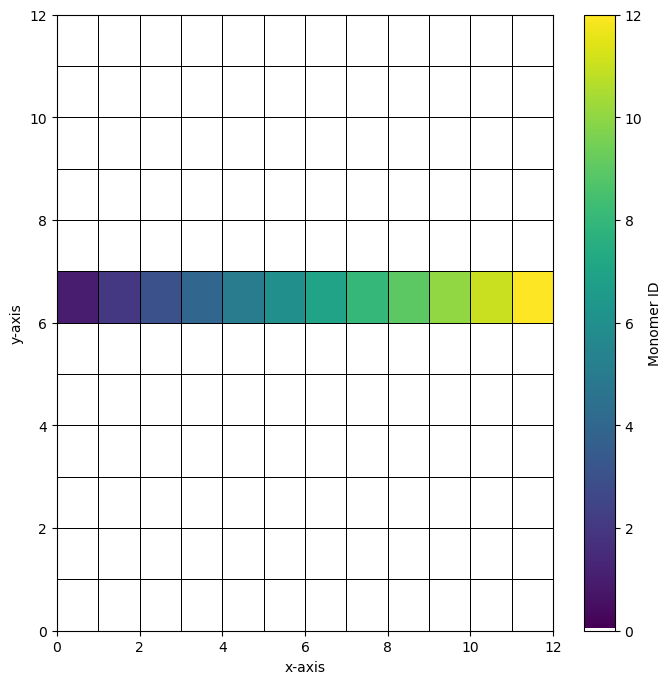

In [ ]:
from matplotlib.colors import ListedColormap

def visualize_polymer(polymer):
    # Polymer dimentions
    M = int(np.max(polymer[:, 0]) + 1)

    # Empty grid
    grid = np.zeros((M, M))

    # putting the monomers into the grid
    for i, (x, y) in enumerate(polymer):
        grid[int(y), int(x)] = i + 1  

    cmap = ListedColormap(['white'] + plt.cm.viridis.colors)

    # Visualizing
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(grid,  edgecolors='black', linewidth=0.5, cmap=cmap)
    plt.colorbar(label='Monomer ID')
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.show()

polymer = createPolymer(12)
visualize_polymer(polymer)




In [17]:
# 1e)

def isIntact(polymer, N):
    """Checks if a polymer is intact"""
    length = len(polymer)
    for i in range(N-1):
        x_dist = polymer[i+1][0]-polymer[i][0]
        y_dist = polymer[i+1][1]-polymer[i][1]
        distance = np.abs(x_dist + y_dist)
        if distance != 1 or length != N:
            return False
    return True

False